
# Dürreindex nach de Martonne – Update für 2023




## 1. Voraussetzungen installieren


In [1]:

# %pip install geopandas rioxarray rasterio rasterstats xarray matplotlib pandas



## 2. Imports und Modul laden
Das Modul liegt im selben Ordner wie dieses Notebook.


In [1]:

import sys, os
sys.path.append(os.getcwd())

import choropleth_pipeline as cp

import palettes

import geopandas as gpd
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm, TwoSlopeNorm



## 3. Pfade und Quellen konfigurieren


In [2]:
# Config

# Vektordaten über Landes-, Kreis- und Gemeindegrenzen vom
# Bundesamt für Kartographie und Geodäsie
VG250_GPKG = "../geometry/DE_VG250.gpkg"

# ESRI ASCII Raster (Jahresmittel) vom Deutschen Wetterdienst (DWD)
# Quelle: https://opendata.dwd.de/climate_environment/CDC/grids_germany/annual/drought_index/
ASC1  = "../data/DWDgrid/Duerreindex/DIMM_17_2021_01.asc"        
ASC2  = "../data/DWDgrid/Duerreindex/DIMM_17_2022_01.asc"
ASC3  = "../data/DWDgrid/Duerreindex/DIMM_17_2023_01.asc"

# Optional: zweites Jahr für Veränderung
# ASC_2005   = "data/Duerreindex/ti_200517.asc"

# Daten laden
sources = [
    cp.SourceSpec(
        name         = "dmi_2021", 
        path         = ASC1, 
        year         = "2021", 
        fallback_crs = "EPSG:31467"
    ),
    cp.SourceSpec(
        name         = "dmi_2022", 
        path         = ASC2, 
        year         = "2022", 
        fallback_crs = "EPSG:31467"
    ),
    cp.SourceSpec(
        name         = "dmi_2023", 
        path         = ASC3, 
        year         = "2023", 
        fallback_crs = "EPSG:31467"
    ),
    # SourceSpec(name="dmi_2005", path=ASC_2005, year="2005", fallback_crs="EPSG:31467"),
]

# Geographie-daten laden
# ARS = Amtlicher Regionalschlüssel
vg = cp.VG250Spec(gpkg_path=VG250_GPKG, id_col = "ARS")


## 4. Aggregation: Raster
Ergebnis ist ein GeoDataFrame mit Spalten wie `{name}_mean`.


In [3]:
# Ein Landkreis oder Kreis (abgekürzt: Kr) ist nach deutschem Kommunalrecht ein
# Gemeindeverband und eine Gebietskörperschaft und eine der unteren Ebenen der
# Verwaltungsgliederung Deutschlands. (Wikipedia)

# Achtung: Es gibt kreisfreie Städte wie Berlin und Hamburg!

# all_touched = False verhindert Übergewichtung von Gridzellen, die an
# Grenzflächen liegen
# Es wird der Durchschnitt der Werte über die Kreisgeometrie gebildet
# andere Maße können zugefügt werden

# Target Aggregation mitgeben
# LAN — Länder (Bundesländer)
# KRS — Kreise (Landkreise & kreisfreie Städte)
# GEM — Gemeinden
# RBZ — Regierungsbezirke (nur wo vorhanden)
# CUSTOM — Eigene Regionen (via target_gdf/target_id_col)

gdf = cp.process_sources(
    sources,
    vg,
    stats=("mean",),
    all_touched=False,
    target_level="GEM"   # Aggregation über Landkreise
)

# # Spalte benennen
# value_col = f"{sources[0].name}_mean"

# # Ausgabe des Ergebnisses zur Kontrolle
# gdf[[vg.id_col, value_col]].head()
gdf.head(5)

,ARS,geometry,dmi_2021_mean,dmi_2022_mean,dmi_2023_mean
0,010010000000,"MULTIPOLYGON (((9.41264 54.82263, 9.41315 54.8...",44.812500,41.041667,59.166667
1,010020000000,"MULTIPOLYGON (((10.16915 54.43137, 10.16956 54...",38.801802,35.621622,45.063063
2,010030000000,"MULTIPOLYGON (((10.87682 53.98736, 10.87883 53...",33.989474,28.568421,38.489474
3,010040000000,"MULTIPOLYGON (((9.99544 54.14971, 9.99712 54.1...",43.600000,40.042857,50.842857
4,010510011011,"MULTIPOLYGON (((9.16437 53.94509, 9.16704 53.9...",43.191489,39.361702,55.787234


In [5]:
gdf['3ymean_23'] = (gdf['dmi_2021_mean']+gdf['dmi_2022_mean']+gdf['dmi_2023_mean'])/3

gdf.head(3)

,ARS,geometry,dmi_2021_mean,dmi_2022_mean,dmi_2023_mean,3ymean_23
0,010010000000,"MULTIPOLYGON (((9.41264 54.82263, 9.41315 54.8...",44.812500,41.041667,59.166667,48.340278
1,010020000000,"MULTIPOLYGON (((10.16915 54.43137, 10.16956 54...",38.801802,35.621622,45.063063,39.828829
2,010030000000,"MULTIPOLYGON (((10.87682 53.98736, 10.87883 53...",33.989474,28.568421,38.489474,33.682456


In [8]:
gdf['3ymean_23_z'] = cp.robust_z(gdf['3ymean_23'])
gdf['3ymean_0_100'] = cp.scale_0_100(gdf["3ymean_23_z"],1, 99)
gdf.columns

Index(['ARS', 'geometry', 'dmi_2021_mean', 'dmi_2022_mean', 'dmi_2023_mean',
       '3ymean_23', '3ymean_23_z', '3ymean_0_100'],
      dtype='object')

In [10]:
gdf[['ARS', 'dmi_2021_mean', 'dmi_2022_mean', 'dmi_2023_mean',
       '3ymean_23', '3ymean_23_z', '3ymean_0_100']].to_csv('csv/DMI_Index.csv', index = False)


## 5. De Martonne Klassen festlegen (diskreter Plot mit de Martonne Klassen)
Diskrete Klassen und Labels definieren. Die kontinuierlichen Werte bleiben im DataFrame.


In [6]:
# # De Martonne Klassen (Jahreswerte)
# bins = (-float("inf"), 10, 20, 24, 28, 35, 55, float("inf"))

# labels = (
#     "Arid (<10)",
#     "Semi-arid (10–20)",
#     "Mediterran (20–24)",
#     "Semi-humid (24–28)",
#     "Humid (28–35)",
#     "Sehr humid (35–55)",
#     "Extrem humid (≥55)",
# )

# gdf = cp.classify_discrete(
#     gdf,
#     'dmi_2024_mean',
#     bins=bins, 
#     labels=labels, 
#     class_col="dmi_class"
# )

# # angepasste Farbpalette speziell für den Dürreindex
# colors = cp.DISCRETE_PRESETS["dmi_7"][:len(labels)]


## 6. Karte zeichnen und speichern
Ländergrenzen optional mitzeichnen. Export erfolgt über `save_map`.


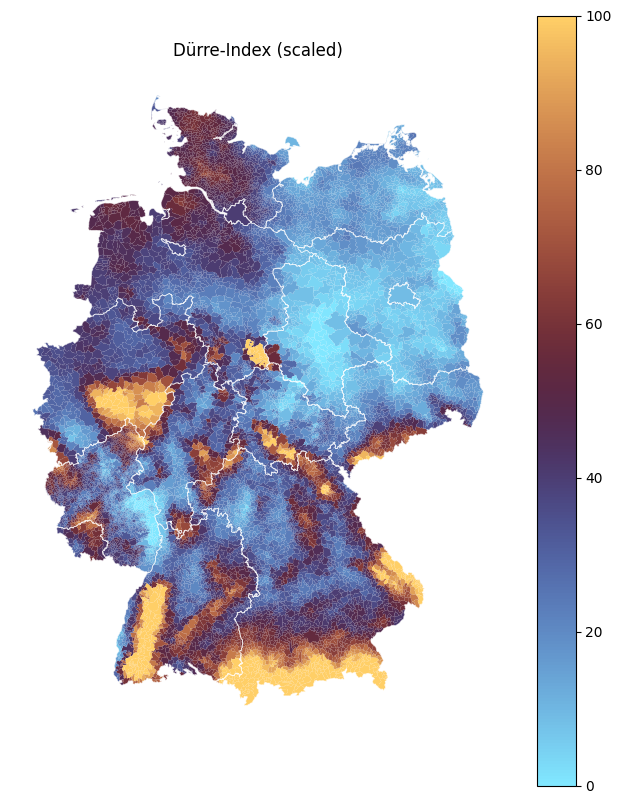

In [13]:
value_col = "3ymean_0_100"
laender = cp.load_level(vg, 'LAN')

fig, ax = cp.plot_choropleth_continuous(
    gdf,
    value_col,
    cmap_name="managua_r",          
    title=f"Dürre-Index (scaled)",
    laender = laender,
    figsize=(8, 10),
    norm = TwoSlopeNorm(vmin=0, vcenter=50, vmax=100) 
)

# Speichern
out_file = cp.save_map(
    fig, 
    filename=f"dmi23_scaled.png", 
    out_dir="exports",
    dpi=300
)